<a href="https://colab.research.google.com/github/carollinemelloo/AnaliseEProjeto/blob/main/PCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import pandas as pd
import seaborn as sns

In [ ]:
def gerar_instancia_tsp(num_cidades, limite=100):
    """Gera coordenadas aleatórias (x, y) para as cidades."""
    np.random.seed(42)
    cidades = [(random.randint(0, limite), random.randint(0, limite)) for _ in range(num_cidades)]
    return cidades

def calcular_distancia(cidade1, cidade2):
    """Calcula a distância Euclidiana (PCV Métrico)."""
    return np.sqrt((cidade1[0] - cidade2[0])**2 + (cidade1[1] - cidade2[1])**2)

def criar_matriz_distancia(cidades):
    """Cria a matriz de distâncias de N x N para acesso rápido."""
    N = len(cidades)
    matriz = np.zeros((N, N))
    for i in range(N):
        for j in range(i + 1, N):
            dist = calcular_distancia(cidades[i], cidades[j])
            matriz[i][j] = dist
            matriz[j][i] = dist
    return matriz

def calcular_custo_rota(rota, matriz_distancia):
    """Calcula o custo total de uma rota (o fitness no AG)."""
    custo = 0
    N = len(rota)
    for i in range(N):
        custo += matriz_distancia[rota[i]][rota[(i + 1) % N]]
    return custo


CIDADES_EXEMPLO = gerar_instancia_tsp(10)
MATRIZ_EXEMPLO = criar_matriz_distancia(CIDADES_EXEMPLO)

Heurística Gulosa (Vizinho Mais Próximo)

In [ ]:
def vizinho_mais_proximo(matriz_distancia, ponto_inicial=0):
    """
    Implementação da Heurística Gulosa do Vizinho Mais Próximo (NN).
    Complexidade: O(N^2)
    """
    N = matriz_distancia.shape[0]
    rota = [ponto_inicial]
    visitado = [False] * N
    visitado[ponto_inicial] = True
    custo = 0

    cidade_atual = ponto_inicial

    for _ in range(N - 1):
        vizinho_mais_proximo = -1
        menor_distancia = float('inf')

        for vizinho in range(N):
            if not visitado[vizinho]:
                dist = matriz_distancia[cidade_atual][vizinho]
                if dist < menor_distancia:
                    menor_distancia = dist
                    vizinho_mais_proximo = vizinho

        if vizinho_mais_proximo != -1:
            rota.append(vizinho_mais_proximo)
            visitado[vizinho_mais_proximo] = True
            cidade_atual = vizinho_mais_proximo


    custo_total = calcular_custo_rota(rota, matriz_distancia)
    return rota, custo_total


rota_nn, custo_nn = vizinho_mais_proximo(MATRIZ_EXEMPLO)
print(f"Custo NN (10 cidades): {custo_nn:.2f}")

Custo NN (10 cidades): 259.75


Meta-Heurística (Algoritmo Genético)

In [ ]:
POP_SIZE = 50
NUM_GERACOES = 200
TAXA_CRUZAMENTO = 0.8
TAXA_MUTACAO = 0.05

def criar_populacao_inicial(N, tamanho_populacao):
    """Gera uma população inicial de rotas aleatórias."""
    populacao = []
    cidades = list(range(N))
    for _ in range(tamanho_populacao):
        random.shuffle(cidades)
        populacao.append(cidades[:])
    return populacao

def selecao_torneio(populacao, matriz_distancia, k=5):
    """
    Seleciona os pais usando o método de Torneio (seleciona o indivíduo com
    o menor custo entre k indivíduos aleatórios).
    """
    melhor_individuo = None
    melhor_custo = float('inf')

    for _ in range(k):
        competidor = random.choice(populacao)
        custo = calcular_custo_rota(competidor, matriz_distancia)
        if custo < melhor_custo:
            melhor_custo = custo
            melhor_individuo = competidor

    return melhor_individuo

def cruzamento_ox1(pai1, pai2):
    """
    Operador de Cruzamento por Ordem 1 (Order Crossover 1 - OX1).
    Essencial para PCV, pois preserva a validade da rota (não repete cidades).
    """
    N = len(pai1)

    ponto1 = random.randint(0, N - 1)
    ponto2 = random.randint(ponto1, N - 1)

    filho = [None] * N
    filho[ponto1:ponto2] = pai1[ponto1:ponto2]

    cidades_nao_presentes = [cidade for cidade in pai2 if cidade not in filho]

    indice_filho = ponto2 % N
    for cidade in cidades_nao_presentes:
        filho[indice_filho] = cidade
        indice_filho = (indice_filho + 1) % N

    return filho

def mutacao_troca(rota, taxa_mutacao):
    """
    Operador de Mutação que troca duas cidades de posição (Swap).
    """
    if random.random() < taxa_mutacao:
        N = len(rota)
        i, j = random.sample(range(N), 2)
        rota[i], rota[j] = rota[j], rota[i]
    return rota

def algoritmo_genetico_tsp(matriz_distancia, pop_size, num_geracoes, taxa_cruzamento, taxa_mutacao):
    """Função principal do Algoritmo Genético."""
    N = matriz_distancia.shape[0]
    populacao = criar_populacao_inicial(N, pop_size)
    melhor_custo_historico = float('inf')
    melhor_rota_historico = None

    for geracao in range(num_geracoes):
        pop_avaliada = [(calcular_custo_rota(cromo, matriz_distancia), cromo) for cromo in populacao]
        pop_avaliada.sort(key=lambda x: x[0])

        melhor_custo_atual = pop_avaliada[0][0]

        if melhor_custo_atual < melhor_custo_historico:
            melhor_custo_historico = melhor_custo_atual
            melhor_rota_historico = pop_avaliada[0][1][:]

        nova_populacao = [pop_avaliada[0][1][:]]

        while len(nova_populacao) < pop_size:
            pai1 = selecao_torneio(populacao, matriz_distancia)
            pai2 = selecao_torneio(populacao, matriz_distancia)

            if random.random() < taxa_cruzamento:
                filho = cruzamento_ox1(pai1, pai2)
                filho = mutacao_troca(filho, taxa_mutacao)
                nova_populacao.append(filho)
            else:
                nova_populacao.append(pai1)

        populacao = nova_populacao[:pop_size]

    return melhor_rota_historico, melhor_custo_historico


rota_ag, custo_ag = algoritmo_genetico_tsp(
    MATRIZ_EXEMPLO, POP_SIZE, NUM_GERACOES, TAXA_CRUZAMENTO, TAXA_MUTACAO
)
print(f"Custo AG (10 cidades): {custo_ag:.2f}")

Custo AG (10 cidades): 209.84


Módulo de Teste e Análise de Desempenho

Iniciando testes comparativos detalhados...
Instância N=10 concluída em 5 repetições.
Instância N=20 concluída em 5 repetições.
Instância N=50 concluída em 5 repetições.
Instância N=80 concluída em 5 repetições.
Instância N=100 concluída em 5 repetições.
Instância N=150 concluída em 5 repetições.
Instância N=200 concluída em 5 repetições.


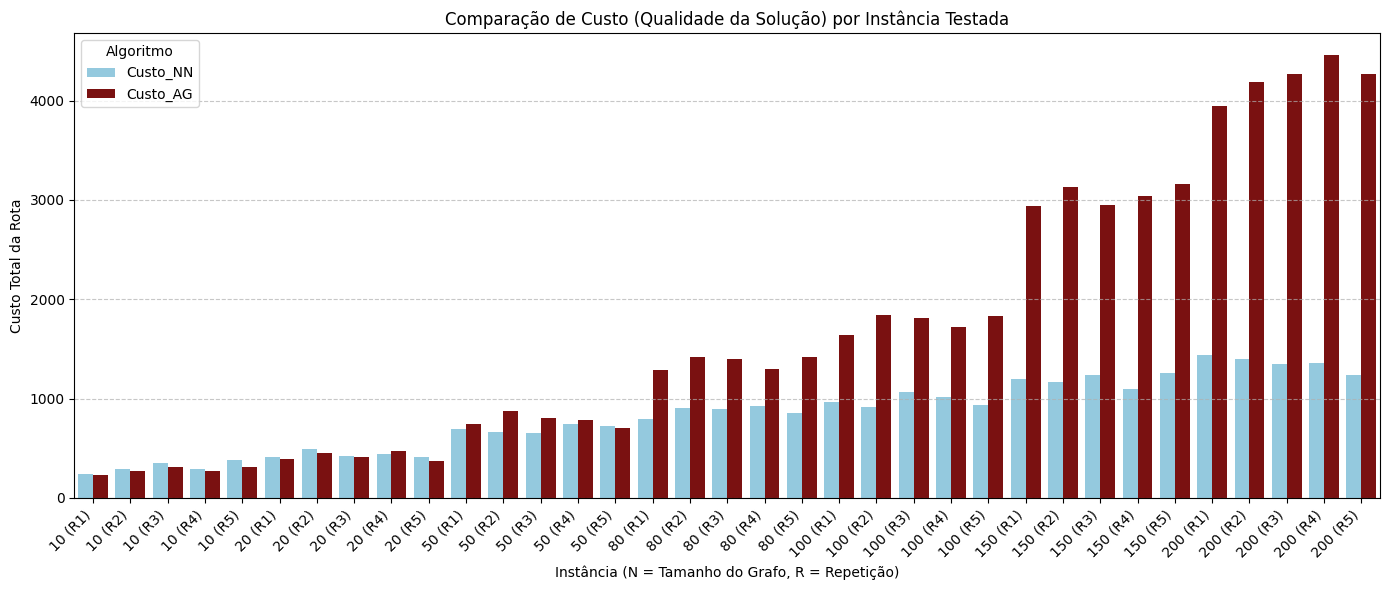


--- Análise da Média (Qualidade e Tempo) por N ---
|        N |   Custo_NN |   Custo_AG |   Tempo_NN |   Tempo_AG |   Fator_Qualidade_NN/AG (p) |
|---------:|-----------:|-----------:|-----------:|-----------:|----------------------------:|
|  10.0000 |   311.3571 |   277.5233 |     0.0000 |     0.5716 |                      1.1219 |
|  20.0000 |   437.5630 |   418.1119 |     0.0001 |     1.1943 |                      1.0465 |
|  50.0000 |   695.0147 |   778.1654 |     0.0005 |     2.8820 |                      0.8931 |
|  80.0000 |   875.0341 |  1363.0946 |     0.0011 |     4.6612 |                      0.6419 |
| 100.0000 |   980.3676 |  1767.4336 |     0.0028 |     6.2075 |                      0.5547 |
| 150.0000 |  1191.9104 |  3043.2213 |     0.0039 |     9.9276 |                      0.3917 |
| 200.0000 |  1354.0858 |  4226.9433 |     0.0068 |    14.3989 |                      0.3203 |


In [ ]:
def executar_testes_detalhados(tamanhos_instancia, num_repeticoes=5):
    """
    Executa os dois algoritmos em tamanhos de instância variados, usando
    time.perf_counter() para medir tempos mais precisos e registrando CADA REPETIÇÃO.
    """
    resultados_detalhados = []

    AG_PARAMS = {'pop_size': 50, 'num_geracoes': 200, 'taxa_cruzamento': 0.8, 'taxa_mutacao': 0.05}

    print("Iniciando testes comparativos detalhados...")

    for N in tamanhos_instancia:
        for i in range(num_repeticoes):
            cidades = gerar_instancia_tsp(N)
            matriz_distancia = criar_matriz_distancia(cidades)

            start_time_nn = time.perf_counter()
            _, custo_nn = vizinho_mais_proximo(matriz_distancia)
            end_time_nn = time.perf_counter()

            start_time_ag = time.perf_counter()
            _, custo_ag = algoritmo_genetico_tsp(matriz_distancia, **AG_PARAMS)
            end_time_ag = time.perf_counter()

            resultados_detalhados.append({
                'N': N,
                'Repeticao': i + 1,
                'Custo_NN': custo_nn,
                'Custo_AG': custo_ag,
                'Tempo_NN': end_time_nn - start_time_nn,
                'Tempo_AG': end_time_ag - start_time_ag,
            })

        print(f"Instância N={N} concluída em {num_repeticoes} repetições.")

    return resultados_detalhados

def plotar_comparacao_por_instancia(dados_detalhados):
    """
    Gera gráficos de barras comparando NN e AG por repetição e tamanho (N).
    Também imprime a análise de média e fator de aproximação relativo.
    """
    df_detalhado = pd.DataFrame(dados_detalhados)

    df_custo = df_detalhado.melt(
        id_vars=['N', 'Repeticao'],
        value_vars=['Custo_NN', 'Custo_AG'],
        var_name='Algoritmo',
        value_name='Custo da Rota'
    )

    plt.figure(figsize=(14, 6))
    sns.barplot(
        data=df_custo,
        x=df_custo['N'].astype(str) + ' (R' + df_custo['Repeticao'].astype(str) + ')',
        y='Custo da Rota',
        hue='Algoritmo',
        palette={'Custo_NN': 'skyblue', 'Custo_AG': 'darkred'}
    )

    plt.title('Comparação de Custo (Qualidade da Solução) por Instância Testada')
    plt.xlabel('Instância (N = Tamanho do Grafo, R = Repetição)')
    plt.ylabel('Custo Total da Rota')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Algoritmo')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    df_media = df_detalhado.groupby('N')[['Custo_NN', 'Custo_AG', 'Tempo_NN', 'Tempo_AG']].mean().reset_index()
    df_media['Fator_Qualidade_NN/AG (p)'] = df_media['Custo_NN'] / df_media['Custo_AG']

    print("\n--- Análise da Média (Qualidade e Tempo) por N ---")
    print(df_media.to_markdown(index=False, floatfmt=".4f"))

TAMANHOS_TESTE = [10, 20, 50, 80, 100, 150, 200]


dados_detalhados = executar_testes_detalhados(TAMANHOS_TESTE)

plotar_comparacao_por_instancia(dados_detalhados)

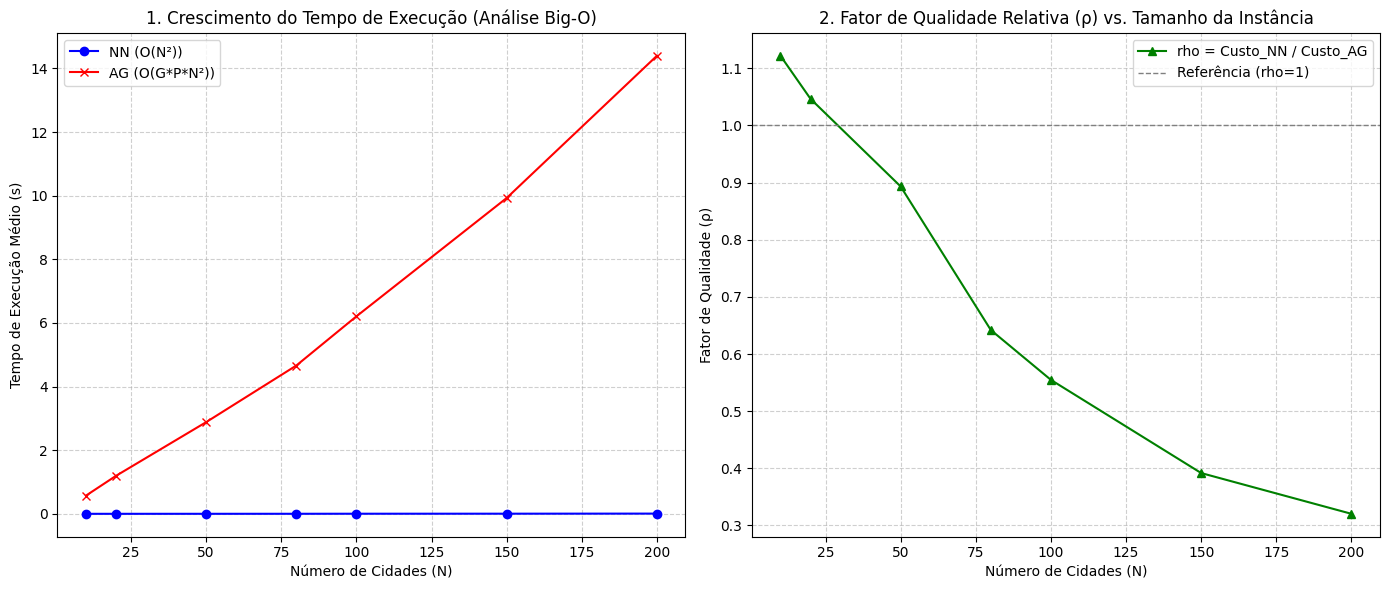

In [ ]:
def plotar_analise_agregada(dados_detalhados):
    """
    Gera gráficos de linha para análise Big-O (Tempo vs. N) e Fator de Aproximação Relativo (rho vs. N).
    """
    df_detalhado = pd.DataFrame(dados_detalhados)

    df_media = df_detalhado.groupby('N')[['Custo_NN', 'Custo_AG', 'Tempo_NN', 'Tempo_AG']].mean().reset_index()
    df_media['Fator_rho'] = df_media['Custo_NN'] / df_media['Custo_AG']

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)

    plt.plot(df_media['N'], df_media['Tempo_NN'], marker='o', label='NN (O(N²))', color='blue')
    plt.plot(df_media['N'], df_media['Tempo_AG'], marker='x', label='AG (O(G*P*N²))', color='red')

    plt.title('1. Crescimento do Tempo de Execução (Análise Big-O)')
    plt.xlabel('Número de Cidades (N)')
    plt.ylabel('Tempo de Execução Médio (s)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.subplot(1, 2, 2)

    plt.plot(df_media['N'], df_media['Fator_rho'], marker='^', label='rho = Custo_NN / Custo_AG', color='green')

    plt.axhline(y=1.0, color='gray', linestyle='--', linewidth=1, label='Referência (rho=1)')

    plt.title('2. Fator de Qualidade Relativa (ρ) vs. Tamanho da Instância')
    plt.xlabel('Número de Cidades (N)')
    plt.ylabel('Fator de Qualidade (ρ)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

if 'dados_detalhados' in locals() and dados_detalhados:
    plotar_analise_agregada(dados_detalhados)
else:
    print("Atenção: A variável 'dados_detalhados' não foi encontrada. Execute a célula de teste primeiro.")

# 🌍 Comparação de Algoritmos: Problema do Caixeiro Viajante (TSP)

Este notebook implementa e compara duas abordagens distintas para resolver o **Problema do Caixeiro Viajante (PCV/TSP)** em um espaço Euclidiano 2D.

## 🚀 Abordagens Implementadas

### 1. Heurística Gulosa: Vizinho Mais Próximo (NN)
* **Estratégia:** Parte de uma cidade inicial e sempre escolhe a cidade não visitada mais próxima.
* **Complexidade:** $O(N^2)$
* **Característica:** Extremamente rápido, mas tende a cair em ótimos locais (soluções sub-ótimas).

### 2. Computação Evolutiva: Algoritmo Genético (AG)
Uma abordagem meta-heurística baseada na seleção natural.
* **Seleção:** Torneio ($k=5$).
* **Cruzamento (Crossover):** *Order Crossover 1* (OX1) — essencial para o TSP pois evita cidades duplicadas.
* **Mutação:** *Swap* (Troca de posições).
* **Parâmetros:**
    * População: 50
    * Gerações: 200
    * Taxa de Cruzamento: 80%
    * Taxa de Mutação: 5%

---

## 📊 Metodologia de Teste

O código executa uma bateria de testes automatizados variando o número de cidades ($N$) de **10 a 200**. Para cada tamanho, são realizadas múltiplas repetições para garantir consistência estatística.

### Indicadores Analisados:
1.  **Custo da Rota (Fitness):** A distância total percorrida (quanto menor, melhor).
2.  **Tempo de Execução:** Medido via `time.perf_counter()` para precisão.
3.  **Fator de Qualidade ($\rho$):** Razão entre o custo do NN e do AG ($\rho = \frac{Custo_{NN}}{Custo_{AG}}$).

## 📈 Visualizações Geradas

Ao executar o código, três análises gráficas serão plotadas:
1.  **Gráfico de Barras:** Comparação direta de custo por instância e repetição.
2.  **Tabela de Médias:** Resumo estatístico dos tempos e custos.
3.  **Análise Agregada:**
    * *Esquerda:* Curva de crescimento do tempo (Análise Big-O).
    * *Direita:* Comportamento da qualidade relativa das soluções conforme o problema cresce.

## 📦 Dependências
O código utiliza as seguintes bibliotecas (já instaladas no Colab):
* `numpy` (Cálculo vetorial)
* `pandas` (Tabulação de dados)
* `matplotlib` & `seaborn` (Visualização de dados)